# Task 1: Generation of linearly-separable data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tools import generate_dataset


# 3.1.1: Generation of linearly separable data

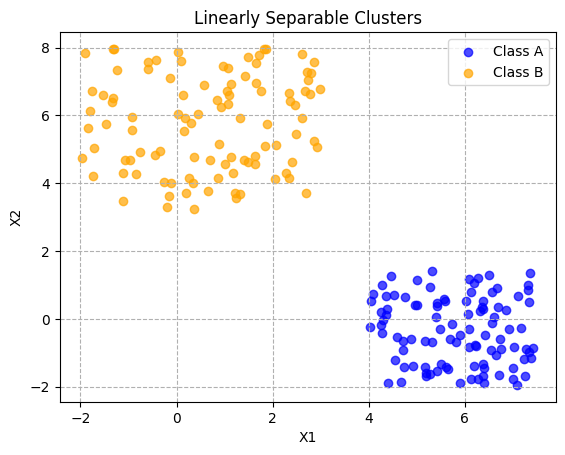

In [2]:
data, labels = generate_dataset()

# Data points for Class A and Class B based on labels
classA_points = data[:, labels == -1]
classB_points = data[:, labels == 1]

# Plotting
plt.scatter(classA_points[0, :], classA_points[1, :], label='Class A', alpha=0.7, color='blue')
plt.scatter(classB_points[0, :], classB_points[1, :], label='Class B', alpha=0.7, color='orange')
plt.grid(True, linestyle='--')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Linearly Separable Clusters')
plt.show()

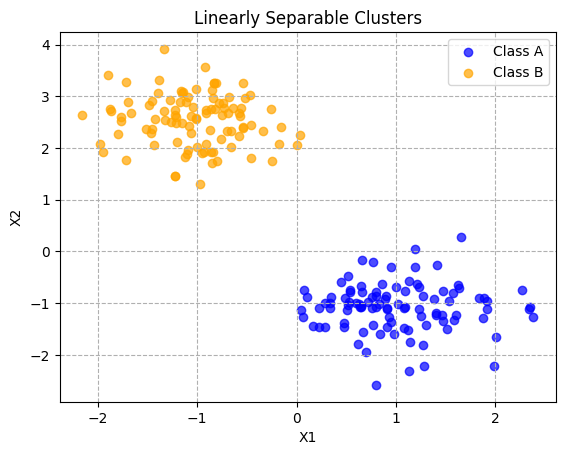

In [3]:
def generate_points(n_A, n_B, mu_A, mu_B, sigma_A, sigma_B, seed=22012025):
    """Generate two classes of 2D points with Gaussian distribution.
    
    Args:
        n_A (int): Number of points in class A
        n_B (int): Number of points in class B
        mu_A (list): Mean [x,y] for class A
        mu_B (list): Mean [x,y] for class B
        sigma_A (float): Standard deviation for class A
        sigma_B (float): Standard deviation for class B
        seed (int): Random seed for reproducibility
        
    Returns:
        tuple: (patterns, targets) where patterns is a 2xN array of points
        and targets is a length N array of class labels (-1 or 1)
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Generate points for each class
    class_A = np.random.randn(2, n_A) * sigma_A + np.array(mu_A).reshape(2, 1)
    class_B = np.random.randn(2, n_B) * sigma_B + np.array(mu_B).reshape(2, 1)
    
    # Combine patterns and targets
    patterns = np.hstack((class_A, class_B))
    targets = np.hstack((np.ones(n_A), -np.ones(n_B)))
    
    # Shuffle the data
    idx = np.random.permutation(n_A + n_B)
    patterns = patterns[:, idx]
    targets = targets[idx]
    
    return patterns, targets


patterns, targets = generate_points(n_A=100, n_B=100, mu_A=[1,-1], mu_B=[-1,2.5], sigma_A=0.5, sigma_B=0.5)

# Data points for Class A and Class B based on labels
classA_points = patterns[:, targets == 1]
classB_points = patterns[:, targets == -1]

# Plotting
plt.scatter(classA_points[0, :], classA_points[1, :], label='Class A', alpha=0.7, color='blue')
plt.scatter(classB_points[0, :], classB_points[1, :], label='Class B', alpha=0.7, color='orange')
plt.legend()
plt.grid(True, linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Linearly Separable Clusters')
plt.show()

In [4]:
def add_bias(patterns):
    """
    Add a bias term to the input patterns.

    Parameters:
        patterns (ndarray): Input patterns of shape (n_features, n_samples).

    Returns:
        ndarray: Patterns with an added bias term, shape (n_features + 1, n_samples).
    """
    # Add a row of ones as the bias term
    bias = np.ones((1, patterns.shape[1]))
    patterns_with_bias = np.concatenate((patterns, bias), axis=0)
    
    return patterns_with_bias


In [5]:
def initialize_weights(n_output, n_input, seed=1):
    """
    Initialize weights with random values from a normal distribution.

    Parameters:
        n_output (int): Number of output neurons.
        n_input (int): Number of input features.
        seed (int, optional): Random seed for reproducibility. Default is 1.

    Returns:
        ndarray: Initialized weights of shape (n_output, n_input).
    """
    np.random.seed(seed)  # Set the random seed for reproducibility
    weights = np.random.normal(loc=0, scale=1, size=(n_output, n_input))
    
    return weights

In [6]:
def error_by_epoch(error_by_epoch, title, color="black", eta=None):
    """
    Plot the error rate by epoch with optional learning rate annotation.

    Parameters:
        error_by_epoch (list or ndarray): List of error values for each epoch.
        title (str): Title of the plot.
        color (str, optional): Color of the plot line. Default is "black".
        eta (float, optional): Learning rate to annotate in the legend. Default is None.

    Returns:
        None
    """
    plt.plot(error_by_epoch, color=color, label=f"Eta {eta}" if eta is not None else None)
    plt.xticks(np.arange(0, len(error_by_epoch)))
    plt.xlabel("Epoch")
    plt.ylabel("1 - Accuracy (Error)")
    plt.title(f"Error by Epoch: {title}")
    plt.legend()


In [7]:
def decision_boundary_by_epoch(patterns, targets, weights_by_epoch, title):
    """
    Plot the decision boundary evolution over epochs.

    Parameters:
        patterns (ndarray): Input patterns (features), shape (2, n_samples).
        targets (ndarray): Target labels, shape (n_samples,).
        weights_by_epoch (list of ndarray): List of weights for each epoch.
        title (str): Title of the plot.

    Returns:
        None
    """
    # Define the scatter plot for data points
    class_a_points = patterns[:, targets == 1]
    class_b_points = patterns[:, targets == -1]

    plt.scatter(class_a_points[0, :], class_a_points[1, :], alpha=0.7, color="blue")
    plt.scatter(class_b_points[0, :], class_b_points[1, :], alpha=0.7, color="orange")
    
    # Generate x-values for decision boundary lines
    x = np.linspace(patterns[0, :].min(), patterns[0, :].max(), 100)
    epochs = len(weights_by_epoch)
    colors = plt.cm.rainbow(np.linspace(0, 1, epochs))

    # Plot decision boundaries at selected epochs
    for epoch, color in zip(range(epochs), colors):
        w1, w2, bias = weights_by_epoch[epoch][0]
        y = -(w1 * x + bias) / w2
        if epoch % 5 == 0:  # Plot every 5 epochs
            plt.plot(x, y, color=color, label=f"Epoch {epoch}")
    
    # Add labels, legend, and grid
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.ylim(patterns[1, :].min(), patterns[1, :].max())
    plt.title(f"Decision Boundary Evolution: {title}")



# 3.1.2: Classification with a single-layer Perceptron & Analysis

1. Apply and compare perceptron learning with the delta learning rule in online (sequential) mode on the generated dataset. 


Adjust the learning rate and study the convergence of the two algorithms

In [8]:
def perceptron_sequential(patterns, targets, weights, eta, epochs):
    """
    Train a Perceptron using the sequential update rule over multiple epochs.

    Parameters:
        patterns (ndarray): Input patterns (features), shape (n_features, n_samples).
        targets (ndarray): Target outputs, shape (n_samples,).
        weights (ndarray): Initial weights, shape (1, n_features + 1).
        eta (float): Learning rate.
        epochs (int): Number of training epochs.

    Returns:
        tuple: Final weights, list of errors per epoch, list of weights per epoch.
    """
    # Copy weights to avoid modifying the original
    weights = weights.copy()
    
    # Add a bias term to input patterns
    patterns = add_bias(patterns)
    
    # Initialize lists to track error rates and weights for each epoch
    error_by_epoch = [np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)]
    weights_by_epoch = [weights.copy()]
    
    # Train for the specified number of epochs
    for epoch in range(epochs):
        for sample_idx in range(patterns.shape[1]):
            # Compute the output for the current sample
            output = np.sign(weights @ patterns[:, sample_idx:sample_idx + 1])
            
            # Calculate the weight update using the sequential Perceptron rule
            delta_weights = -eta * (output - targets[sample_idx]) * patterns[:, sample_idx:sample_idx + 1].T / 2
            
            # Update weights
            weights += delta_weights
        
        # Record weights and error after the epoch
        weights_by_epoch.append(weights.copy())
        error_rate = np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)
        error_by_epoch.append(error_rate)
    
    return weights, error_by_epoch, weights_by_epoch


In [9]:
def delta_rule_sequential(patterns, targets, weights, eta, epochs):
    """
    Train a model using the Delta Rule with sequential updates over multiple epochs.

    Parameters:
        patterns (ndarray): Input patterns (features), shape (n_features, n_samples).
        targets (ndarray): Target outputs, shape (n_samples,).
        weights (ndarray): Initial weights, shape (n_output, n_features + 1).
        eta (float): Learning rate.
        epochs (int): Number of training epochs.

    Returns:
        tuple: Final weights, list of errors per epoch, list of weights per epoch.
    """
    # Copy weights to avoid modifying the original
    weights = weights.copy()
    
    # Add bias term to input patterns
    patterns = add_bias(patterns)
    
    # Initialize lists to track errors and weights for each epoch
    error_by_epoch = [np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)]
    weights_by_epoch = [weights.copy()]
    
    # Train over specified number of epochs
    for epoch in range(epochs):
        for sample_idx in range(patterns.shape[1]):
            # Compute weight adjustment using the Delta Rule
            delta_weights = -eta * ((weights @ patterns[:, sample_idx:sample_idx + 1]) - targets[sample_idx]) @ patterns[:, sample_idx:sample_idx + 1].T
            
            # Update weights
            weights += delta_weights
        
        # Record weights and error after the epoch
        weights_by_epoch.append(weights.copy())
        error_rate = np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)
        error_by_epoch.append(error_rate)
    
    return weights, error_by_epoch, weights_by_epoch


In [10]:
weights = initialize_weights(n_output=1, n_input=patterns.shape[0]+1, seed=1)
epochs = 30
eta = 0.001

# Training with perceptron learning in batch mode
weights_p, error_by_epoch_p, weights_by_epoch_p = \
    perceptron_sequential(patterns, targets, weights, eta, epochs)

# Training with delta rule in batch mode
weights_dr, error_by_epoch_dr, weights_by_epoch_dr = \
    delta_rule_sequential(patterns, targets, weights, eta, epochs)

# Perceptron vs Delta Rule - Sequential Mode

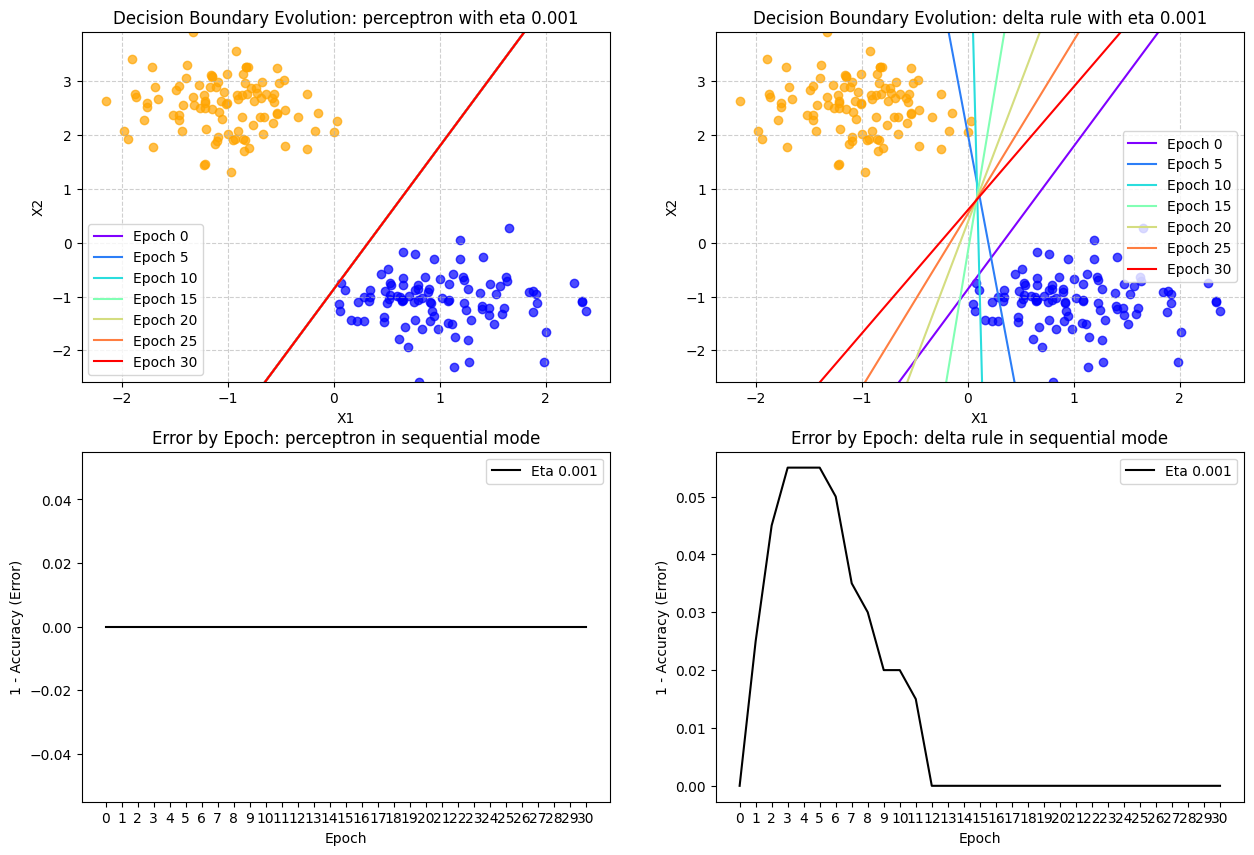

In [11]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(221)
decision_boundary_by_epoch(patterns, targets, weights_by_epoch_p, title="perceptron with eta "+str(eta))

fig.add_subplot(222)
decision_boundary_by_epoch(patterns, targets, weights_by_epoch_dr, title="delta rule with eta "+str(eta))

fig.add_subplot(223)
error_by_epoch(error_by_epoch_p, title="perceptron in sequential mode", eta=eta)

fig.add_subplot(224)
error_by_epoch(error_by_epoch_dr, title="delta rule in sequential mode", eta=eta)

# Perceptron vs Delta Rule (Sequential Mode) - Different Learning Rates

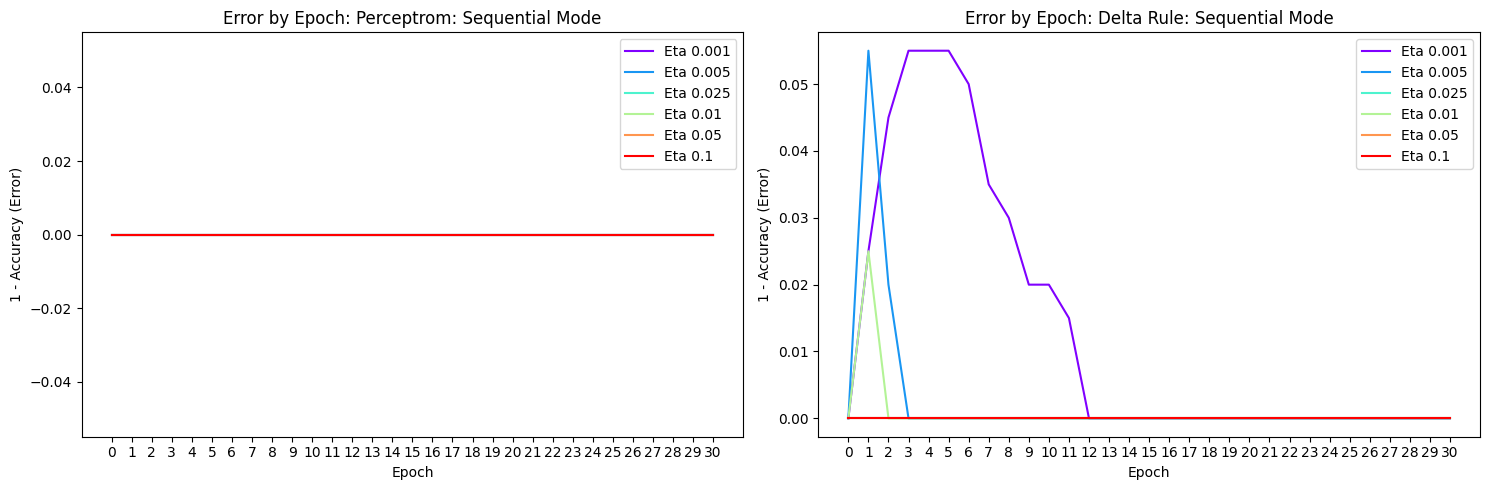

In [12]:
fig = plt.figure(figsize=(15, 5))
etas = [0.001, 0.005, 0.025, 0.01, 0.05, 0.1]
colors = plt.cm.rainbow(np.linspace(0, 1, len(etas)))

# Delta rule in batch and sequential mode
for eta, color in zip(etas, colors):
    # Delta rule in batch mode
    ax1 = plt.subplot(121)
    weights_p_seq, error_by_epoch_p_seq, _ = perceptron_sequential(patterns, targets, weights, eta, epochs)
    error_by_epoch(error_by_epoch_p_seq, title="Perceptrom: Sequential Mode", color=color, eta=eta)
    
    # Delta rule in sequential mode
    ax2 = plt.subplot(122)
    weights_dr_seq, error_by_epoch_dr_seq, _ = delta_rule_sequential(patterns, targets, weights, eta, epochs)
    error_by_epoch(error_by_epoch_dr_seq, title="Delta Rule: Sequential Mode", color=color, eta=eta)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Delta rule: Sequential vs Batch mode

In [13]:
def perceptron_batch(patterns, targets, weights, eta, epochs):
    """
    Train a Perceptron using batch updates over multiple epochs.

    Parameters:
        patterns (ndarray): Input patterns (features), shape (n_features, n_samples).
        targets (ndarray): Target outputs, shape (n_samples,).
        weights (ndarray): Initial weights, shape (1, n_features + 1).
        eta (float): Learning rate.
        epochs (int): Number of training epochs.

    Returns:
        tuple: Final weights, list of errors per epoch, list of weights per epoch.
    """
    weights = weights.copy()
    patterns = add_bias(patterns)
    
    # Initialize lists to track error rates and weights for each epoch
    error_by_epoch = [np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)]
    weights_by_epoch = [weights.copy()]
    
    # Train for the specified number of epochs
    for epoch in range(epochs):
        # Compute batch weight adjustment
        delta_weights = -eta * (np.sign(weights @ patterns) - targets) @ patterns.T / 2
        
        # Update weights
        weights += delta_weights
        
        # Record weights and error after each epoch
        weights_by_epoch.append(weights.copy())
        error_rate = np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)
        error_by_epoch.append(error_rate)
    
    return weights, error_by_epoch, weights_by_epoch


In [14]:
def delta_rule_batch(patterns, targets, weights, eta, epochs):
    """
    Train a model using the Delta Rule with batch updates over multiple epochs.

    Parameters:
        patterns (ndarray): Input patterns (features), shape (n_features, n_samples).
        targets (ndarray): Target outputs, shape (n_samples,).
        weights (ndarray): Initial weights, shape (1, n_features + 1).
        eta (float): Learning rate.
        epochs (int): Number of training epochs.

    Returns:
        tuple: Final weights, list of errors per epoch, list of weights per epoch.
    """
    weights = weights.copy()
    patterns = add_bias(patterns)
    
    error_by_epoch = [np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)]
    weights_by_epoch = [weights.copy()]
    
    # Train for the specified number of epochs
    for epoch in range(epochs):
        # Compute batch weight adjustment using the Delta Rule
        delta_weights = -eta * ((weights @ patterns) - targets) @ patterns.T
        
        # Update weights
        weights += delta_weights
        
        # Record weights and error after each epoch
        weights_by_epoch.append(weights.copy())
        error_rate = np.mean(np.abs(np.sign(weights @ patterns) - targets) / 2)
        error_by_epoch.append(error_rate)
    
    return weights, error_by_epoch, weights_by_epoch


In [15]:
weights = initialize_weights(n_output=1, n_input=data.shape[0]+1, seed=1)
epochs = 50
eta = 0.01

# Training with delta rule in sequential mode
weights_dr_seq, error_by_epoch_dr_seq, weights_by_epoch_dr_seq = \
    delta_rule_sequential(patterns, targets, weights, eta, epochs)

# Training with delta rule in batch mode
weights_dr_batch, error_by_epoch_dr_batch, weights_by_epoch_dr_batch = \
    delta_rule_batch(patterns, targets, weights, eta, epochs)

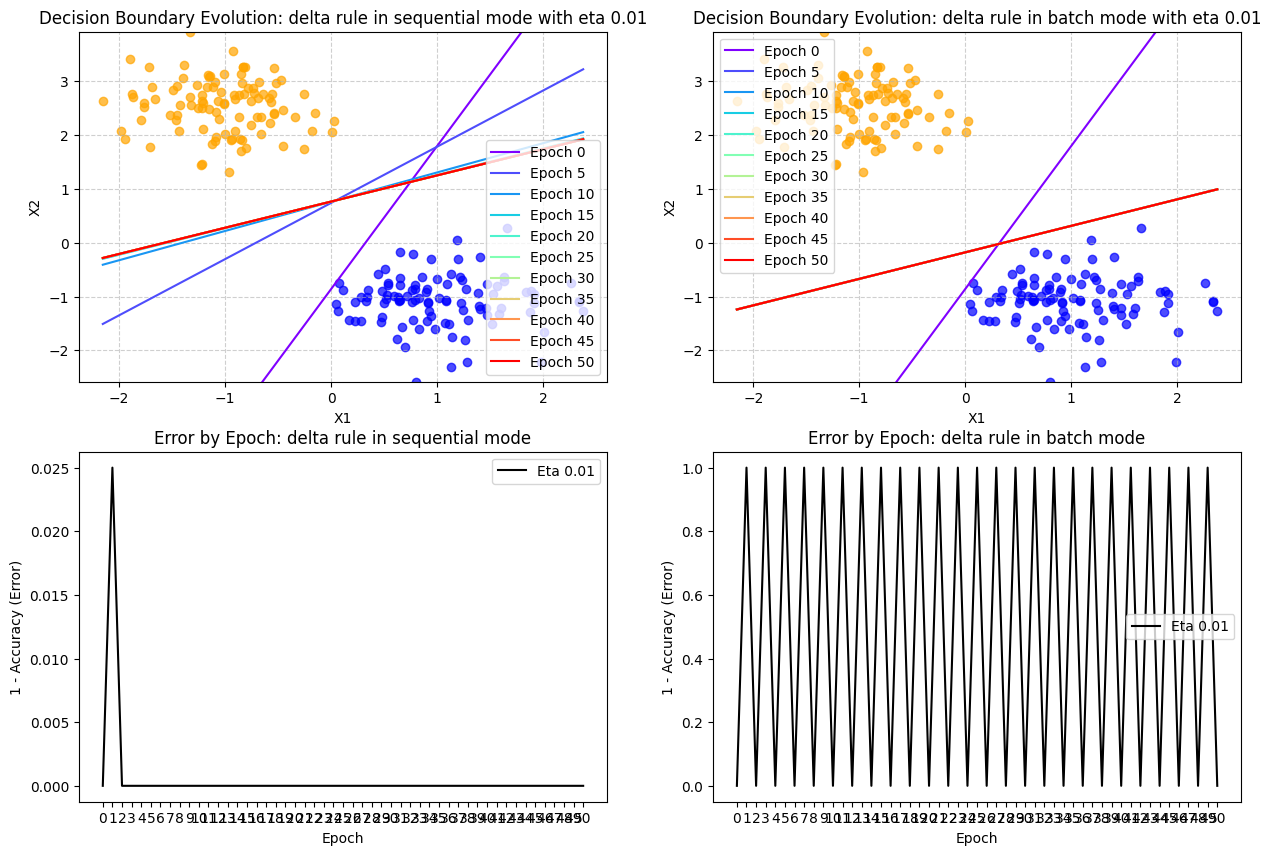

In [16]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(221)
decision_boundary_by_epoch(patterns, targets, weights_by_epoch_dr_seq, title="delta rule in sequential mode with eta "+str(eta))

fig.add_subplot(222)
decision_boundary_by_epoch(patterns, targets, weights_by_epoch_dr_batch, title="delta rule in batch mode with eta "+str(eta))

fig.add_subplot(223)
error_by_epoch(error_by_epoch_dr_seq, title="delta rule in sequential mode", eta=eta)

fig.add_subplot(224)
error_by_epoch(error_by_epoch_dr_batch, title="delta rule in batch mode", eta=eta)

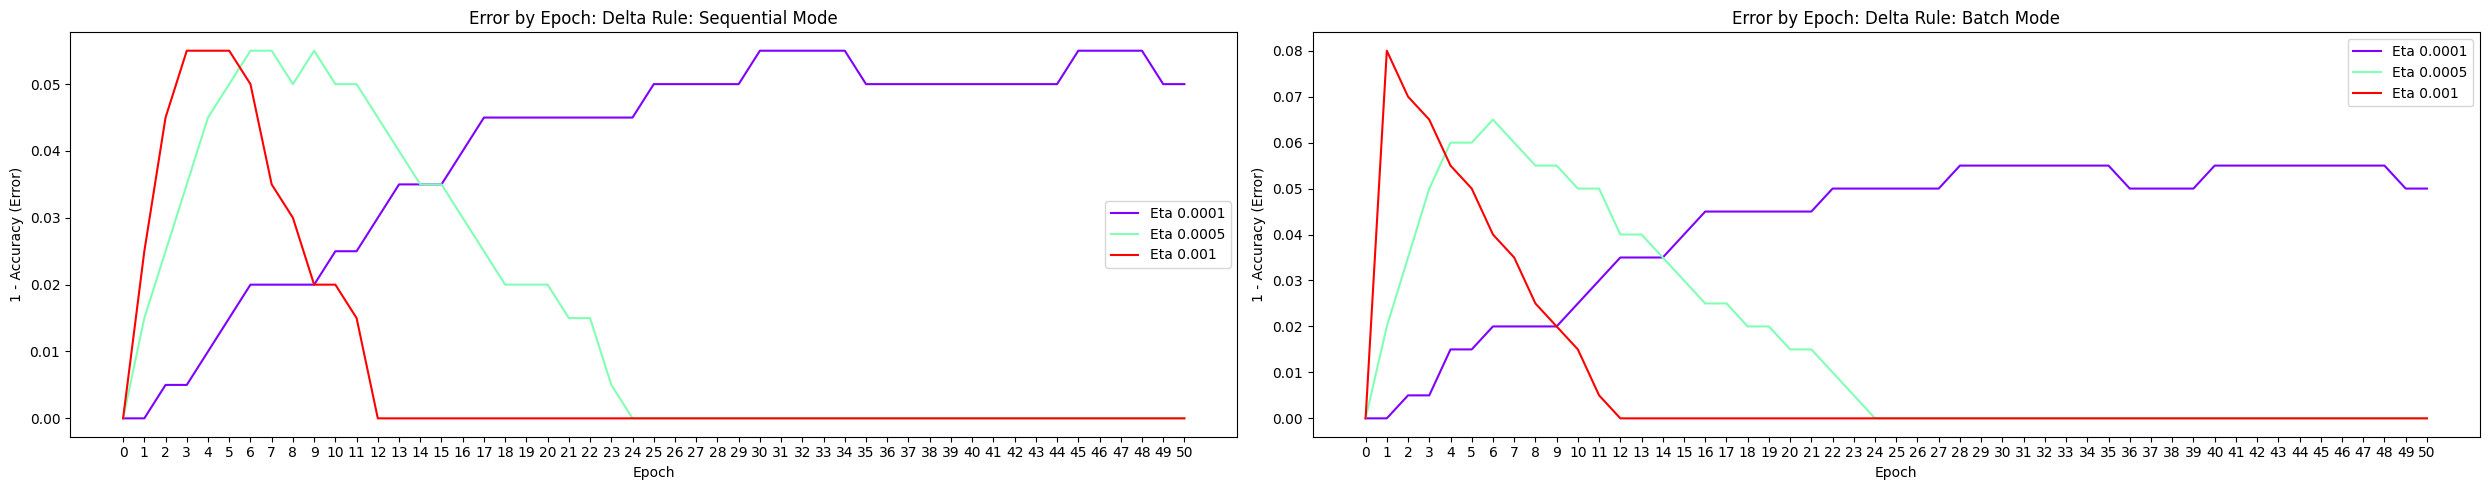

In [17]:
fig = plt.figure(figsize=(25, 5))
etas = [0.0001, 0.0005, 0.001]
colors = plt.cm.rainbow(np.linspace(0, 1, len(etas)))

# Delta rule in batch and sequential mode
for eta, color in zip(etas, colors):
    # Delta rule in sequential mode
    ax1 = plt.subplot(121)
    weights_dr_seq, error_by_epoch_dr_seq, _ = delta_rule_sequential(patterns, targets, weights, eta, epochs)
    error_by_epoch(error_by_epoch_dr_seq, title="Delta Rule: Sequential Mode", color=color, eta=eta)
    
    # Delta rule in batch mode
    ax2 = plt.subplot(122)
    weights_dr_batch, error_by_epoch_dr_batch, _ = delta_rule_batch(patterns, targets, weights, eta, epochs)
    error_by_epoch(error_by_epoch_dr_batch, title="Delta Rule: Batch Mode", color=color, eta=eta)


# Adjust layout and display
plt.tight_layout()
plt.show()

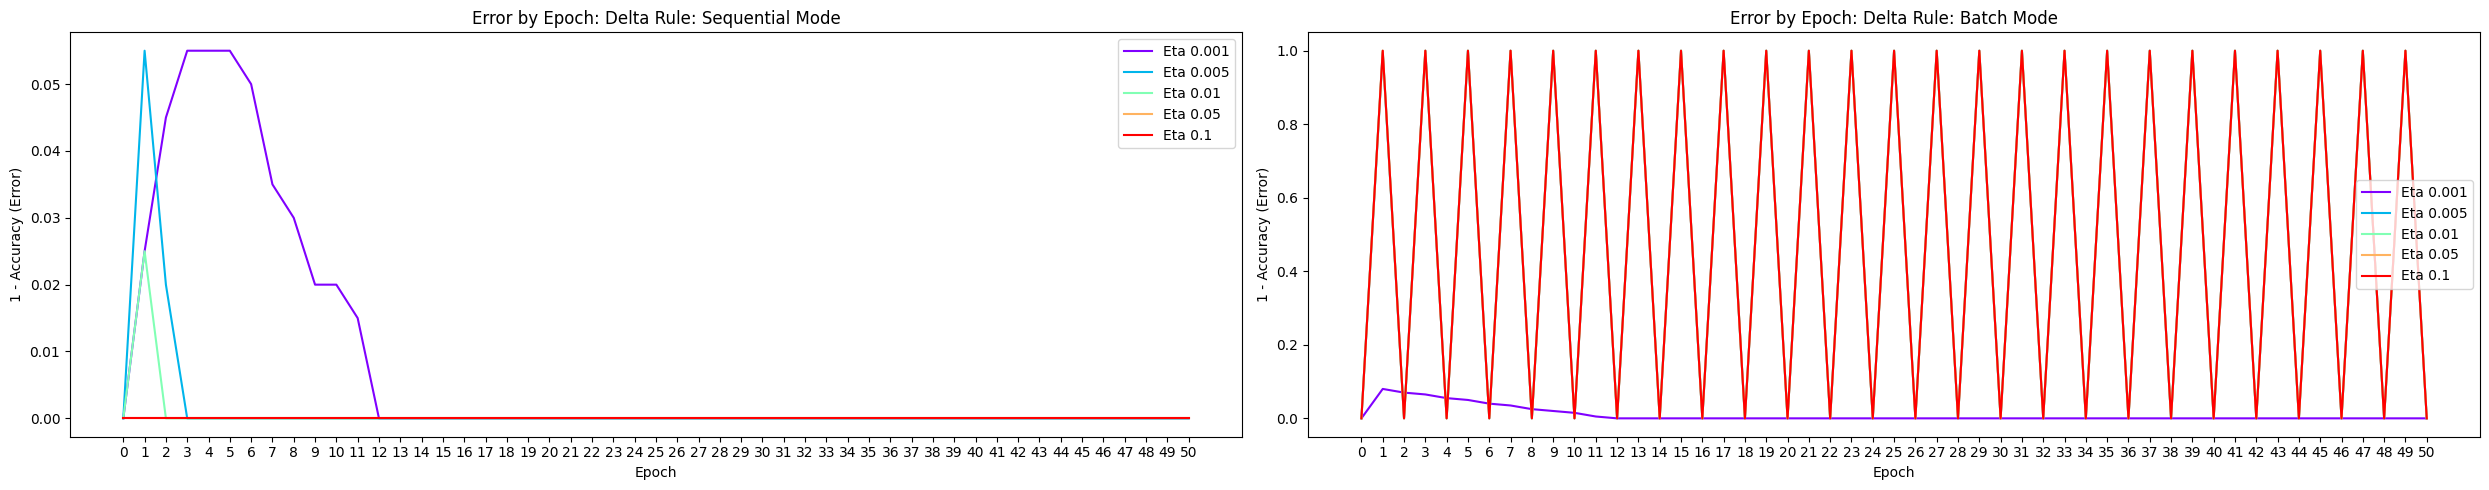

In [18]:
fig = plt.figure(figsize=(25, 5))
etas = [0.001, 0.005, 0.01, 0.05, 0.1]
colors = plt.cm.rainbow(np.linspace(0, 1, len(etas)))

# Delta rule in batch and sequential mode
for eta, color in zip(etas, colors):
    # Delta rule in sequential mode
    ax1 = plt.subplot(121)
    weights_dr_seq, error_by_epoch_dr_seq, _ = delta_rule_sequential(patterns, targets, weights, eta, epochs)
    error_by_epoch(error_by_epoch_dr_seq, title="Delta Rule: Sequential Mode", color=color, eta=eta)
    
    # Delta rule in batch mode
    ax2 = plt.subplot(122)
    weights_dr_batch, error_by_epoch_dr_batch, _ = delta_rule_batch(patterns, targets, weights, eta, epochs)
    error_by_epoch(error_by_epoch_dr_batch, title="Delta Rule: Batch Mode", color=color, eta=eta)


# Adjust layout and display
plt.tight_layout()
plt.show()

3. Remove the bias, train your network with the delta rule in batch mode and test its behaviour. In what cases would the perceptron without
bias converge and classify correctly all data samples? Please verify your
hypothesis by adjusting data parameters, mA and mB.


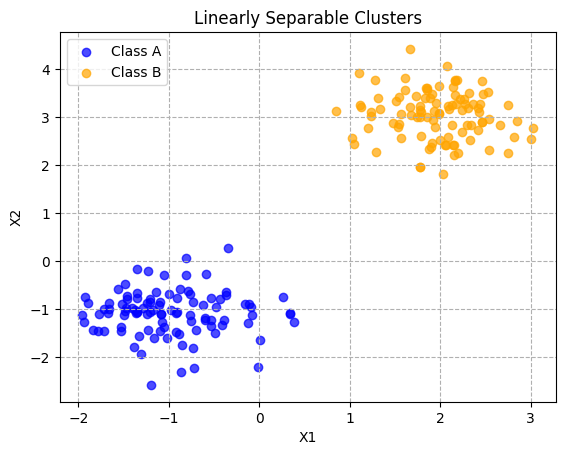

In [19]:
patterns, targets = generate_points(n_A=100, n_B=100, mu_A=[-1,-1], mu_B=[2,3], sigma_A=0.5, sigma_B=0.5)

# Data points for Class A and Class B based on labels
classA_points = patterns[:, targets == 1]
classB_points = patterns[:, targets == -1]

# Plotting
plt.scatter(classA_points[0, :], classA_points[1, :], label='Class A', alpha=0.7, color='blue')
plt.scatter(classB_points[0, :], classB_points[1, :], label='Class B', alpha=0.7, color='orange')
# plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
# plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True, linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Linearly Separable Clusters')
plt.show()

Single-layer perceptron with delta rule WITHOUT bias

In [20]:
def delta_rule_no_bias(patterns, targets, weights, eta, epochs):
    weights = weights.copy()
    # patterns = add_bias(patterns)
    # Iterate epochs saving error and weight at each epoch
    error_by_epoch = [np.mean(abs(np.sign(weights@patterns)-targets)/2)]
    weights_by_epoch = [weights]
    for i in range(epochs):
        delta_weights = -eta*((weights@patterns)-targets)@patterns.T
        weights = weights + delta_weights
        weights_by_epoch.append(weights)
        error_by_epoch.append(np.mean(abs(np.sign(weights@patterns)-targets)/2))
    
    return(weights, error_by_epoch, weights_by_epoch)

In [21]:
epochs = 100
eta = 0.001

# Training delta rule in batch mode with bias
weights = initialize_weights(n_output=1, n_input=patterns.shape[0]+1, seed=1)
weights_dr, error_by_epoch_dr, weights_by_epoch_dr = \
    delta_rule_batch(patterns, targets, weights, eta, epochs)

# Training delta rule in batch mode without bias
weights_no_bias = initialize_weights(n_output=1, n_input=patterns.shape[0], seed=1)
weights_dr_no_bias, error_by_epoch_dr_no_bias, weights_by_epoch_dr_no_bias = \
    delta_rule_no_bias(patterns, targets, weights_no_bias, eta, epochs)

C:\Users\deez\AppData\Local\Temp\ipykernel_14408\2727441189.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


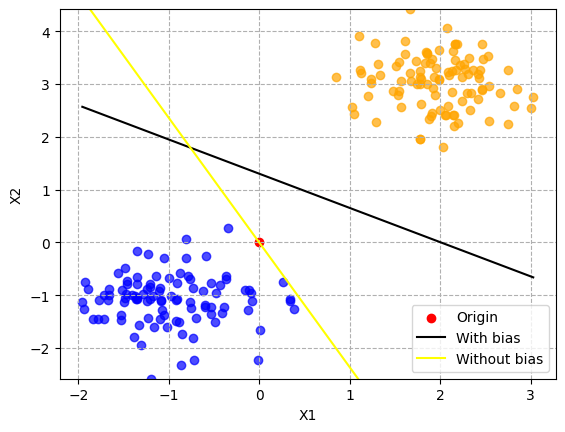

In [22]:
plt.scatter(classA_points[0, :], classA_points[1, :], alpha=0.7, color='blue')
plt.scatter(classB_points[0, :], classB_points[1, :], alpha=0.7, color='orange')
# plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
# plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True, linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(0, 0, c="red", label="Origin")
plt.ylim((min(patterns[1,:]), max(patterns[1,:])))
x = np.linspace(min(patterns[0,:]), max(patterns[0,:]), 100)

# Decision boundary with bias
w1, w2, w0 = weights_dr[0]
y = -(w1*x+w0)/w2
plt.plot(x, y, c="black", label="With bias")

# Decision boundary without bias
w1_nobias, w2_nobias = weights_dr_no_bias[0]
y_nobias = -(w1_nobias*x)/w2_nobias
plt.plot(x, y_nobias, c="yellow", label="Without bias")

plt.legend()
plt.grid(True)

C:\Users\deez\AppData\Local\Temp\ipykernel_14408\2727441189.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


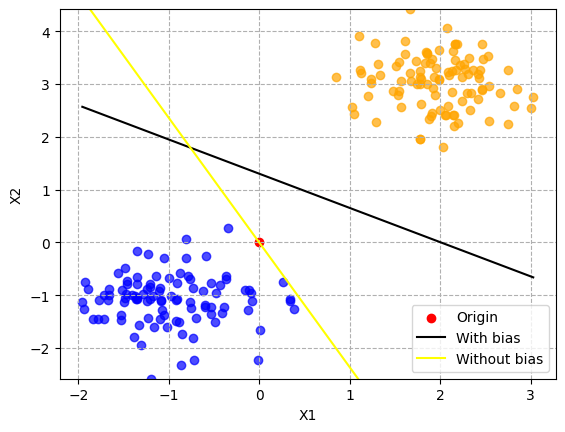

In [23]:
plt.scatter(classA_points[0, :], classA_points[1, :], alpha=0.7, color='blue')
plt.scatter(classB_points[0, :], classB_points[1, :], alpha=0.7, color='orange')
# plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
# plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True, linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(0, 0, c="red", label="Origin")
plt.ylim((min(patterns[1,:]), max(patterns[1,:])))
x = np.linspace(min(patterns[0,:]), max(patterns[0,:]), 100)

# Decision boundary with bias
w1, w2, w0 = weights_dr[0]
y = -(w1*x+w0)/w2
plt.plot(x, y, c="black", label="With bias")

# Decision boundary without bias
w1_nobias, w2_nobias = weights_dr_no_bias[0]
y_nobias = -(w1_nobias*x)/w2_nobias
plt.plot(x, y_nobias, c="yellow", label="Without bias")

plt.legend()
plt.grid(True)